# Metode Random Forest

## Import Libraries

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import Counter

import pandas as pd
import pandas.io.formats.html
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import warnings
import nltk

warnings.filterwarnings("ignore", category=FutureWarning)

nltk.download("punkt")
nltk.download('punkt_tab') 
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset Config

In [2]:
DATASET_DIR = "smsa_doc-sentiment-prosa"

In [3]:
df_train = pd.read_csv(f"{DATASET_DIR}/train_preprocess.tsv", sep="\t", header=None)
df_valid = pd.read_csv(f"{DATASET_DIR}/valid_preprocess.tsv", sep="\t", header=None)
df_test_unmasked = pd.read_csv(f"{DATASET_DIR}/test_preprocess.tsv", sep="\t", header=None)
df_test_masked = pd.read_csv(f"{DATASET_DIR}/test_preprocess_masked_label.tsv", sep="\t", header=None)

with open(f"{DATASET_DIR}/vocab_uncased.txt", "r") as f:
    vocab = f.read().splitlines()

In [4]:
df_train.columns = ["text", "emotion"]
df_valid.columns = ["text", "emotion"]
df_test_unmasked.columns = ["text", "emotion"]
df_test_masked.columns = ["text", "emotion"]

df_train.sample(n=10, random_state=1)

,text,emotion
7030,"dapat rekomendasi makan di sini dari teman , k...",positive
2095,aduh pak tak usah kau marah-marah tak jelas be...,negative
7168,tempat nya walaupun kecil tapi cocok untuk mak...,positive
7969,paling juara desert di sini . beragam pilihan ...,positive
6320,zionis adalah bangsa paling sombong sekaligus ...,negative
6136,makanan di sini tidak pernah mengecewakan . se...,positive
4687,bangga banget punya pak jokowi sebagai preside...,positive
9934,wow ini indomie keju nya banyak amat sampai su...,positive
7868,saya biasanya menonton channel global tv,neutral
4865,walau aku suka pamer 2 jari tapi hati aku tida...,positive


In [5]:
df_valid.sample(n=10, random_state=1)

,text,emotion
1179,tidak amburadul,positive
255,"ini foton pakai handphone xiaomi note 4 , tamp...",negative
304,baru kali ini saya menikmati makanan sunda . s...,positive
403,bagi penggemar kopi susu mampirlah ke sini . a...,positive
75,kita makan di sini karena terjebak macet dan s...,positive
119,"bagus tempat , bagus makanan . pokok nya tidak...",positive
912,gue enggak mau jadi ikutan goblok seperti yang...,negative
1073,nikmati mi ayam atau mi chai shu yang enak di ...,positive
496,customer service indohome tidak pernah gagal d...,positive
1161,di valley kami sekeluarga sangat senang meliha...,positive


In [6]:
df_test_unmasked.sample(n=10, random_state=1)

,text,emotion
304,aku kecewa dengan pelayanan hotel yang semalam...,negative
340,artis cowok pop banci semua .,negative
47,aplikasi tipu . sialan . mengembalikan duit gu...,negative
67,udahlah kecewa jakarta dapet nya anies - sandi...,negative
479,kerja dari pagi sampai pagi lagi itu cuma baka...,neutral
485,tidur yang cukup tiap hari nya bisa bikin bada...,neutral
310,"tidak ada enak nya makan di sana , bakso tidak...",negative
31,"saya hilang 2.5 juta dari apa ini karena , ter...",negative
249,pengiriman barang menggunakan jne sangat memua...,positive
90,"menyesal tidak sih ganti handphone , dari ipho...",negative


In [7]:
df_test_masked.sample(n=10, random_state=1)

,text,emotion
304,aku kecewa dengan pelayanan hotel yang semalam...,neutral
340,artis cowok pop banci semua .,neutral
47,aplikasi tipu . sialan . mengembalikan duit gu...,neutral
67,udahlah kecewa jakarta dapet nya anies - sandi...,neutral
479,kerja dari pagi sampai pagi lagi itu cuma baka...,neutral
485,tidur yang cukup tiap hari nya bisa bikin bada...,neutral
310,"tidak ada enak nya makan di sana , bakso tidak...",neutral
31,"saya hilang 2.5 juta dari apa ini karena , ter...",neutral
249,pengiriman barang menggunakan jne sangat memua...,neutral
90,"menyesal tidak sih ganti handphone , dari ipho...",neutral


## Preprocessing

In [8]:
def to_lowercase(text):
    return text.lower()

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens]
    return ' '.join(tokens)

In [9]:
df_train['text'] = df_train['text'].apply(to_lowercase)
df_valid['text'] = df_valid['text'].apply(to_lowercase)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(to_lowercase)
df_test_masked['text'] = df_test_masked['text'].apply(to_lowercase)

df_train['text'] = df_train['text'].apply(tokenize)
df_valid['text'] = df_valid['text'].apply(tokenize)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(tokenize)

In [10]:
df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


## Exploratory Data Analysis

C:\Users\User\AppData\Local\Temp/ipykernel_18292/3760294676.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([f"{emotion} {emotion_emoticons[emotion]}" for emotion in emotion_counts.index], rotation=0)


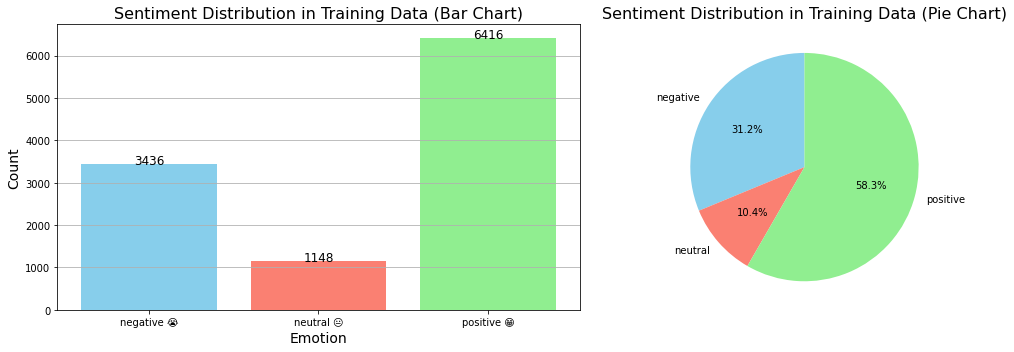

emotion
negative    3436
neutral     1148
positive    6416
Name: text, dtype: int64


In [11]:
emotion_emoticons = {
    'positive': '😁',
    'negative': '😭',
    'neutral': '😐'
}

emotion_counts = df_train.groupby('emotion').text.count()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].bar(emotion_counts.index, emotion_counts, color=['skyblue', 'salmon', 'lightgreen'])
axs[0].set_title("Sentiment Distribution in Training Data (Bar Chart)", fontsize=16)
axs[0].set_xlabel("Emotion", fontsize=14)
axs[0].set_ylabel("Count", fontsize=14)
axs[0].set_xticklabels([f"{emotion} {emotion_emoticons[emotion]}" for emotion in emotion_counts.index], rotation=0)
axs[0].yaxis.grid(True)

for i, count in enumerate(emotion_counts):
    axs[0].text(i, count + 0.5, str(count), ha='center', fontsize=12)

emotion_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon', 'lightgreen'], ax=axs[1])
axs[1].set_title("Sentiment Distribution in Training Data (Pie Chart)", fontsize=16)
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(emotion_counts)

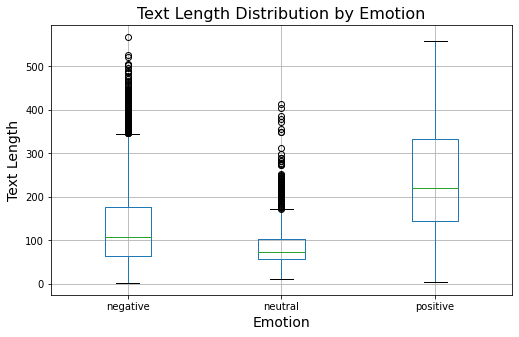

In [12]:
df_train['text_length'] = df_train['text'].apply(len)

fig, ax = plt.subplots(figsize=(8, 5))
df_train.boxplot(column='text_length', by='emotion', ax=ax)
ax.set_title("Text Length Distribution by Emotion", fontsize=16)
ax.set_xlabel("Emotion", fontsize=14)
ax.set_ylabel("Text Length", fontsize=14)
plt.suptitle('')
plt.show()


C:\Users\User\AppData\Local\Temp/ipykernel_18292/2102747433.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)
C:\Users\User\AppData\Local\Temp/ipykernel_18292/2102747433.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)
C:\Users\User\AppData\Local\Temp/ipykernel_18292/2102747433.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)


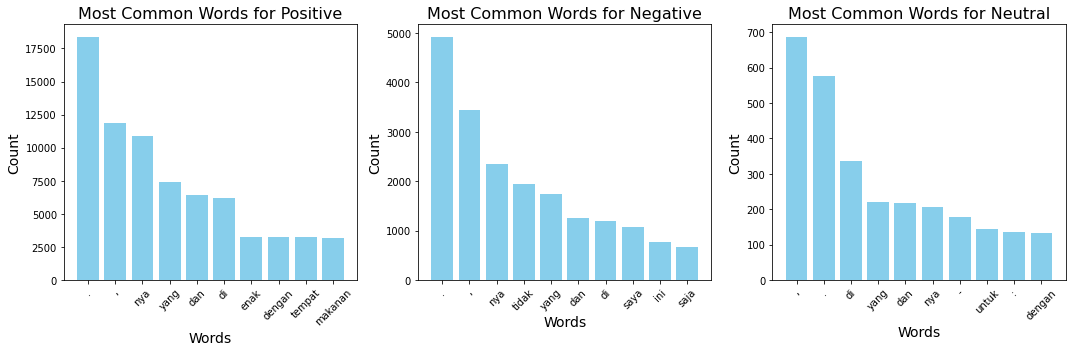

In [13]:
def common_words(emotion):
    words = ' '.join(df_train[df_train['emotion'] == emotion]['text']).split()
    words = [word for word in words if word.lower() not in stopwords.words('english')]
    return Counter(words).most_common(10)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, emotion in zip(axs, emotion_emoticons.keys()):
    common = common_words(emotion)
    words, counts = zip(*common)
    ax.bar(words, counts, color=['skyblue'] * len(words))
    ax.set_title(f'Most Common Words for {emotion.capitalize()}', fontsize=16)
    ax.set_xlabel("Words", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_xticklabels(words, rotation=45)

plt.tight_layout()
plt.show()


## Traning Preparation

 ### Encode Emotion Column

In [14]:
emotion_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

df_train['emotion'] = df_train['emotion'].replace(emotion_encoding)
df_valid['emotion'] = df_valid['emotion'].replace(emotion_encoding)
df_test_unmasked['emotion'] = df_test_unmasked['emotion'].replace(emotion_encoding)
df_test_masked['emotion'] = df_test_masked['emotion'].replace(emotion_encoding)

### Train and Validation

In [15]:
cleaned_vocab = [string.strip() for string in vocab if string.strip()]
cleaned_vocab = list(dict.fromkeys(cleaned_vocab))
vectorizer = CountVectorizer(vocabulary=cleaned_vocab)

X_train = vectorizer.transform(df_train['text'])
y_train = df_train['emotion']
X_valid = vectorizer.transform(df_valid['text'])
y_valid = df_valid['emotion']
X_test = vectorizer.transform(df_test_unmasked['text'])
y_test = df_test_unmasked['emotion']

### Report and Visualizer

In [16]:
def class_report_validation(y_valid, y_valid_pred):
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f"Accuracy\t: {accuracy}")
  print(f'Precision\t: {precision}')
  print(f'Recall\t\t: {recall}')
  print(f'F1-Score\t: {f1}\n')

  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy = accuracy_score(y_test, y_test_pred)
  precision = precision_score(y_test, y_test_pred, average='macro')
  recall = recall_score(y_test, y_test_pred, average='macro')
  f1 = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy\t: {accuracy}')
  print(f'Test Precision\t: {precision}')
  print(f'Test Recall\t: {recall}')
  print(f'Test F1-Score\t: {f1}\n')

  print(classification_report(y_test, y_test_pred, target_names=['negative', 'neutral', 'positive']))

def visualize_misclassifications(df_test_unmasked, y_test_pred, criterion):
    df_test_unmasked['predicted_emotion'] = y_test_pred
    misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]

    misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
    total_count = df_test_unmasked.shape[0]
    misclassified_percentage = (misclassified_count / total_count) * 100

    print(f'Banyak data yang salah diprediksi: {misclassified_count} ({misclassified_percentage:.2f}%)')

    emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
    misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
    misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)

    misclassified_counts = misclassified.groupby('emotion').size()

    emotion_emoticons = {
        'positive': '😁',
        'negative': '😭',
        'neutral': '😐'
    }

    fig, ax = plt.subplots(figsize=(8, 5))
    misclassified_counts.plot(kind='bar', color=['salmon', 'lightblue', 'lightgreen'], ax=ax)

    ax.set_title(f"Misclassification Distribution for {criterion} Criterion", fontsize=16)
    ax.set_xlabel('True Emotions', fontsize=14)
    ax.set_ylabel('Count of Misclassifications', fontsize=14)

    ax.set_xticklabels([f"{emotion} {emotion_emoticons[emotion]}" for emotion in misclassified_counts.index], rotation=0)

    for i, count in enumerate(misclassified_counts):
        ax.text(i, count + 0.5, str(count), ha='center', fontsize=12)

    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nExamples of Misclassifications:")
    misclassified_samples = misclassified[['text', 'emotion', 'predicted_emotion']].sample(n=5, random_state=1)

    for index, row in misclassified_samples.iterrows():
        true_emotion_emoticon = emotion_emoticons[row['emotion']]
        predicted_emotion_emoticon = emotion_emoticons[row['predicted_emotion']]
        print(f"Text: {row['text']}")
        print(f"  True Emotion: {row['emotion']} {true_emotion_emoticon}")
        print(f"  Predicted Emotion: {row['predicted_emotion']} {predicted_emotion_emoticon}")
        print('-' * 80)


## Experiment 1 : Default Criterion (Gini)

In [17]:
clf_model = RandomForestClassifier()
clf_model.fit(X_train, y_train)

RandomForestClassifier()

### Validation

In [18]:
y_valid_pred = clf_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.8634920634920635
Precision	: 0.8578710361077594
Recall		: 0.7737619747915958
F1-Score	: 0.804068880059727

              precision    recall  f1-score   support

    negative       0.80      0.81      0.80       394
     neutral       0.88      0.56      0.69       131
    positive       0.90      0.94      0.92       735

    accuracy                           0.86      1260
   macro avg       0.86      0.77      0.80      1260
weighted avg       0.86      0.86      0.86      1260



### Test

In [19]:
y_test_pred = clf_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.678
Test Precision	: 0.737161019814702
Test Recall	: 0.6037467434526258
Test F1-Score	: 0.6138170532369692

              precision    recall  f1-score   support

    negative       0.60      0.91      0.72       204
     neutral       0.81      0.28      0.42        88
    positive       0.81      0.62      0.70       208

    accuracy                           0.68       500
   macro avg       0.74      0.60      0.61       500
weighted avg       0.72      0.68      0.66       500



### Misclassified

Banyak data yang salah diprediksi: 161 (32.20%)


C:\Users\User\AppData\Local\Temp/ipykernel_18292/1653389020.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_18292/1653389020.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


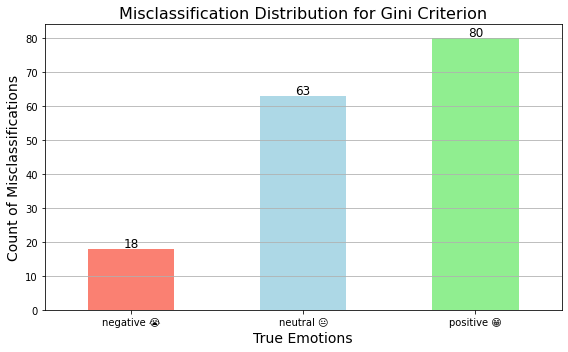


Examples of Misclassifications:
Text: daftar harga dispenser 2018 terbaik yang ada di blibli.com memuat banyak produk . salah satu nya adalah miyako wdp - 200 dispenser . produk ini merupakan dispenser dengan penempatan galon di bawah sehingga anda tidak perlu mengangkat galon saat akan mengisi air .
  True Emotion: neutral 😐
  Predicted Emotion: positive 😁
--------------------------------------------------------------------------------
Text: adab di media sosial itu jelas , kok . suka silakan like , mengikuti . tidak suka , unfoll / block , simpel . dan kita memiliki hak yang sama untuk melakukan nya .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: bandung itu kota paling nyaman buat ditempatkan .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: senang banget liat sandi maju cawapres , untuk 

In [20]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "Gini")

## Experiment 2 : Entropy Criterion

In [21]:
clf_model = RandomForestClassifier(criterion="entropy")
clf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

### Validation

In [22]:
y_valid_pred = clf_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.8626984126984127
Precision	: 0.8651612304385611
Recall		: 0.7816725181437967
F1-Score	: 0.8124378596210323

              precision    recall  f1-score   support

    negative       0.80      0.81      0.80       394
     neutral       0.91      0.60      0.72       131
    positive       0.89      0.94      0.91       735

    accuracy                           0.86      1260
   macro avg       0.87      0.78      0.81      1260
weighted avg       0.86      0.86      0.86      1260



### Test

In [23]:
y_test_pred = clf_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.678
Test Precision	: 0.7490526357558082
Test Recall	: 0.5929144385026738
Test F1-Score	: 0.5970391849073069

              precision    recall  f1-score   support

    negative       0.60      0.93      0.73       204
     neutral       0.83      0.23      0.36        88
    positive       0.82      0.62      0.71       208

    accuracy                           0.68       500
   macro avg       0.75      0.59      0.60       500
weighted avg       0.73      0.68      0.65       500



### Misclassified

Banyak data yang salah diprediksi: 161 (32.20%)


C:\Users\User\AppData\Local\Temp/ipykernel_18292/1653389020.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_18292/1653389020.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


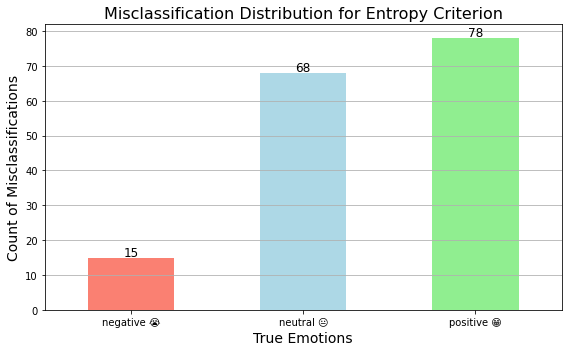


Examples of Misclassifications:
Text: kalau tidak suka gaperlu didukung mas , dukung saja yang menurut mas daus itu bisa bawa indonesia jauh lebih baik . yang penting kita harus menomorsatukan asas etika .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: maaf ini oot . yang hape nya xiaomi , bisa bantu aku tidak . ini kalau aku lagi buka twit atau saya begitu suka menang . nah yang aku lingkarkan merah itu aplikasi yang menghilang begitu . ada yang tahu kenapa dan bagaimana cara menyembuhkan nya :
  True Emotion: neutral 😐
  Predicted Emotion: positive 😁
--------------------------------------------------------------------------------
Text: kalau mau jalan-jalan melihat pulau paling cantik , datang saja ke pulau saumlaki yang ada di maluku .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: senang

In [24]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "Entropy")

## Experiment 3 : Log Loss Criterion

In [25]:
clf_model = RandomForestClassifier(criterion="log_loss")
clf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss')

### Validation

In [26]:
y_valid_pred = clf_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.8563492063492063
Precision	: 0.8544296027614608
Recall		: 0.7760818554827932
F1-Score	: 0.8055315136399566

              precision    recall  f1-score   support

    negative       0.79      0.80      0.79       394
     neutral       0.89      0.60      0.71       131
    positive       0.89      0.93      0.91       735

    accuracy                           0.86      1260
   macro avg       0.85      0.78      0.81      1260
weighted avg       0.86      0.86      0.85      1260



### Test

In [27]:
y_test_pred = clf_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.656
Test Precision	: 0.715325366546329
Test Recall	: 0.5752548105489281
Test F1-Score	: 0.57762445187706

              precision    recall  f1-score   support

    negative       0.58      0.92      0.71       204
     neutral       0.77      0.23      0.35        88
    positive       0.79      0.58      0.67       208

    accuracy                           0.66       500
   macro avg       0.72      0.58      0.58       500
weighted avg       0.70      0.66      0.63       500



### Misclassified

Banyak data yang salah diprediksi: 172 (34.40%)


C:\Users\User\AppData\Local\Temp/ipykernel_18292/1653389020.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_18292/1653389020.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


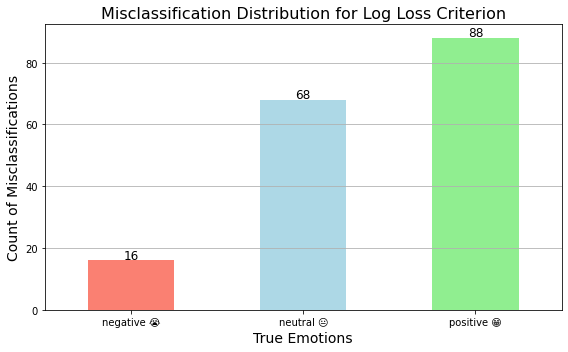


Examples of Misclassifications:
Text: asli ya gue suka banget sama alur cerita film kafir , sederhana , tapi dapat makna nya .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: paling suka sama orang yang tidak pernah mengeluh kalau lagi kerja .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: xiaomi . karena gue pakai xiaomi sekarang , sebelumnya oppo f1 . lebih suka xiaomi saja , baterai nya kuat . gue puas banget sih dengan xiaomi .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: informasi tambahan bahwa untuk pembayaran rp 2 juta yang bapak lakukan tidak menjadikan limit menjadi rp 7 juta , melainkan pembayaran tersebut akan mengurangi tagihan yang sedang berjalan . jika kartu kredit dalam keada

In [28]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "Log Loss")

## Experiment 4 : Hyperparameter Tuning

In [35]:
def evaluate_and_visualize_grid_search(X_train, y_train, X_valid, y_valid):
    parameters = {'criterion': ['gini', 'entropy', 'log_loss'], 'n_estimators': [10, 50, 100]}

    grid_search = GridSearchCV(RandomForestClassifier(), parameters, scoring='f1_macro', refit=True)
    grid_search.fit(X_train, y_train)

    results_df = pd.DataFrame(grid_search.cv_results_)

    sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
    print("Top Grid Search Results:")
    print(sorted_results[['param_criterion', 'param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score']].head())

    fig, ax = plt.subplots(figsize=(10, 6))

    pivot_table = results_df.pivot_table(index='param_n_estimators', columns='param_criterion', values='mean_test_score')
    pivot_table.plot(kind='bar', ax=ax)
    
    ax.set_title('Comparison of CLF Criterion and N_Estimators values based on F1-Score', fontsize=16)
    ax.set_xlabel('N_Estimators', fontsize=14)
    ax.set_ylabel('Mean F1-Score', fontsize=14)
    ax.legend(title="Criterion", fontsize=12)

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    print(f"\nBest model: {best_model}")
    print(f"Best cross-validation score (F1-macro): {best_score:.4f}")

    y_valid_pred = best_model.predict(X_valid)

    print("\nEvaluation on validation set complete.")

Top Grid Search Results:
  param_criterion param_n_estimators  mean_test_score  std_test_score  \
5         entropy                100         0.788216        0.008691   
7        log_loss                 50         0.783838        0.010248   
8        log_loss                100         0.783215        0.011919   
4         entropy                 50         0.783065        0.005334   
1            gini                 50         0.778034        0.007174   

   rank_test_score  
5                1  
7                2  
8                3  
4                4  
1                5  


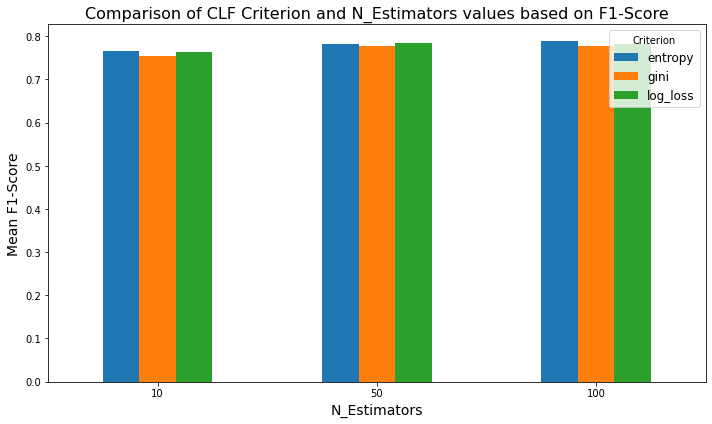


Best model: RandomForestClassifier(criterion='entropy')
Best cross-validation score (F1-macro): 0.7882

Evaluation on validation set complete.


In [36]:
evaluate_and_visualize_grid_search(X_train, y_train, X_valid, y_valid)

In [38]:
clf_model = RandomForestClassifier(criterion="entropy", n_estimators=100)
clf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

### Validation

In [39]:
y_valid_pred = clf_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.8650793650793651
Precision	: 0.8693548423544483
Recall		: 0.7859090947832098
F1-Score	: 0.8165163380362735

              precision    recall  f1-score   support

    negative       0.79      0.82      0.80       394
     neutral       0.92      0.60      0.73       131
    positive       0.90      0.94      0.92       735

    accuracy                           0.87      1260
   macro avg       0.87      0.79      0.82      1260
weighted avg       0.87      0.87      0.86      1260



### Test

In [40]:
y_test_pred = clf_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.67
Test Precision	: 0.7221203529928523
Test Recall	: 0.5842560217560218
Test F1-Score	: 0.5863505021784876

              precision    recall  f1-score   support

    negative       0.59      0.92      0.72       204
     neutral       0.76      0.22      0.34        88
    positive       0.82      0.62      0.70       208

    accuracy                           0.67       500
   macro avg       0.72      0.58      0.59       500
weighted avg       0.71      0.67      0.65       500



### Misclassified

Banyak data yang salah diprediksi: 165 (33.00%)


C:\Users\User\AppData\Local\Temp/ipykernel_18292/1653389020.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_18292/1653389020.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


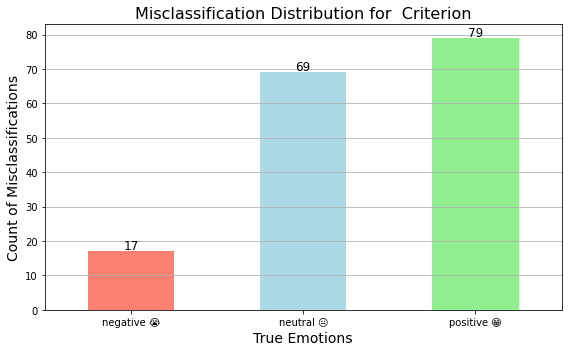


Examples of Misclassifications:
Text: daftar harga dispenser 2018 terbaik yang ada di blibli.com memuat banyak produk . salah satu nya adalah miyako wdp - 200 dispenser . produk ini merupakan dispenser dengan penempatan galon di bawah sehingga anda tidak perlu mengangkat galon saat akan mengisi air .
  True Emotion: neutral 😐
  Predicted Emotion: positive 😁
--------------------------------------------------------------------------------
Text: adab di media sosial itu jelas , kok . suka silakan like , mengikuti . tidak suka , unfoll / block , simpel . dan kita memiliki hak yang sama untuk melakukan nya .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: di sekitar istana bogor , kita bisa kasih makan rusa langsung kalau rusa-rusa nya lagi dikeluarkan .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Tex

In [41]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "")